# Latent Dirichlet Allocation (LDA)

LDA это вероятностная тематическая модель. Совместное распределение имеет следующий вид:
$$p(W, Z, \Theta, \Phi | \alpha, \eta) = \prod_{d=1}^D \Big( p(\theta_d | \alpha) \prod_{n=1}^{N_d} p(w_{d,n} | z_{d,n}, \Phi) p(z_{d,n} | \theta_d) \Big) \prod_{t=1}^T p(\phi_t | \eta) $$

Где:
$$p(\theta_d | \alpha) = Dir(\theta_d | \alpha)$$

$$p(w_{d,n} | z_{d,n}, \Phi) = Categorical(W_{d,n} | \phi_{z_{d,n}})$$

$$p(z_{d,n} | \theta_d) = Categorical(z_{d,n} | \theta_d)$$

$$p(\phi_t | \eta) = Dir(\phi_t | \eta)$$

В данном задании, вам предстоит применить тематическую модель LDA к датасету NIPS-papers. Нужно установить Python библиотеку `gensim` (её можно установить с помощью `pip`).

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot
%matplotlib inline

import gensim

import logging

gensim.models.ldamodel.logger.setLevel(logging.ERROR)

Скачайте датасет и поместите его в папку с ноутбуком: 
http://www.cs.nyu.edu/~roweis/data/nips12raw_str602.mat

Код ниже выполняет необходимую предобработку данных.

In [2]:
nips12 = scipy.io.loadmat('nips12raw_str602.mat', squeeze_me=True)

# матрица размера <число документов> x <число слов>
counts = nips12['counts'].T

# оставим 2013 (~2000) наиболее употребимих слов
words_mask = np.ravel(counts.sum(axis=0) >= 121)
counts = counts[:, words_mask]

# отображение id -> word (необходимо для gensim)
nips12_id2word = {i: w for (i, w) in enumerate(nips12['wl'][words_mask])}

# отображение word -> id (необходимо для pyLDAvis)
nips12_word2id = {w: i for (i, w) in enumerate(nips12['wl'][words_mask])}

# Год проведения конференции. Значение 0 соответсвует 1988, 1 - 1989, и т.д.
nips12_issue = np.array([int(name[4:6]) for name in nips12['docnames']])

# Заголовки статей
nips12_titles = nips12['ptitles']

# Полный корпус в формате gensim
full_corpus = gensim.matutils.Scipy2Corpus(counts)

stream = np.random.RandomState(seed=123)
subset_mask = stream.rand(counts.shape[0]) <= 0.1

# Маленький корпус из 10% случайных статей для ускорения экспериментов
small_corpus = gensim.matutils.Scipy2Corpus(counts[subset_mask, :])

Gensim использует итеративный подход к выводу в модели LDA. Для получения новых значений вариационных параметров выполняется `iterations` итераций вариационного вывода. Далее, новые значения "блэндятся" со старыми (значениями из предыдущей итерации EM-алгоритма) посредством вычисления взвешенного среднего. Эта процедура повторяется `num_passes` раз. Такой подход позволяет предотвратить "застревание" метода в локальных оптимумах.

Используйте следующий шаблон для запуска LDA модели в Gensim. Сейчас мы используем подвыборку для ускорения вычислений.

Замечание: нижняя оценка связана с метрикой perplexity, которая обычно используется в естественных языках: $perplexity = exp(-bound)$

In [3]:
num_topics = 10  # число тем в модели LDA
alpha = [0.1] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
iterations = 50  # число итераций вариационного вывода
num_passes = 5  # число проходов по датасету


small_lda = gensim.models.LdaModel(
    corpus=small_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42
)
print('ELBO = {0:.4f}'.format(small_lda.bound(small_corpus)))

ELBO = -1494880.4774


Исследуйте влияние значений параметров `iterations` и `num_passes` на значние нижней оценки обученной модели.

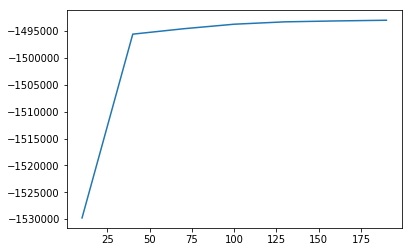

In [4]:
kwargs = {'corpus':small_corpus,
    'passes':num_passes,
    'num_topics':num_topics,
    'alpha':alpha,
    'iterations':iterations,
    'id2word':nips12_id2word,
    'eval_every':0,
    'random_state':42}
dif_iters = []
for iterations in range(10,191,30):
    kwargs['iterations'] = iterations
    small_lda = gensim.models.LdaModel(**kwargs)
    dif_iters += [small_lda.bound(small_corpus)]
    
pyplot.plot(range(10,191,30), dif_iters)

In [16]:
dif_num_passes = []
for num_passes in range(5,16,5):
    kwargs['passes'] = num_passes
    small_lda = gensim.models.LdaModel(**kwargs)
    dif_num_passes += [small_lda.bound(small_corpus)]

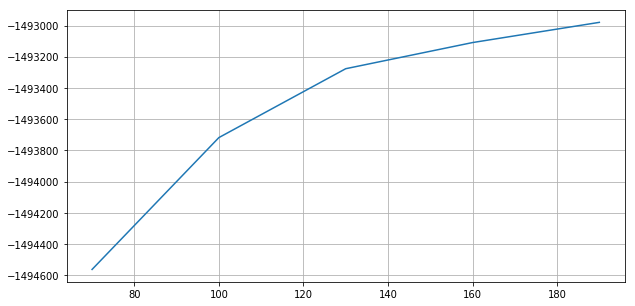

In [13]:
pyplot.figure(figsize=(10,5))
pyplot.plot(range(10,191,30)[-5:], dif_iters[-5:])
pyplot.grid(True)

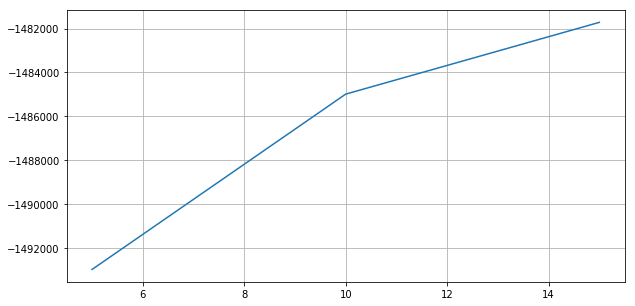

In [17]:
pyplot.figure(figsize=(10,5))
pyplot.plot(range(5,16,5), dif_num_passes)
pyplot.grid(True)

Исследуйте чувствительность нижней вариационную оценки к параметру априорного распределения $\alpha$. Используйте симметричные значения $\alpha$.

In [21]:
dif_alphas = []
for alpha in range(-3,4):
    kwargs['alpha'] = [np.exp(alpha)]*kwargs['num_topics']
    small_lda = gensim.models.LdaModel(**kwargs)
    dif_alphas += [small_lda.bound(small_corpus)]

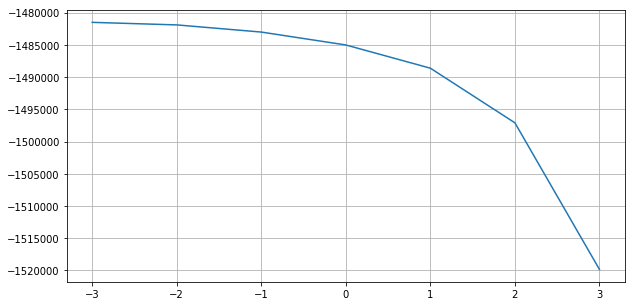

In [22]:
pyplot.figure(figsize=(10,5))
pyplot.plot(range(-3,4), dif_alphas)
pyplot.grid(True)


Обучите лучшую найденую модель на полной выборке.

In [23]:
num_topics = 10  # число тем в модели LDA
alpha = [1e-3] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
iterations = 200  # число итераций вариационного вывода
num_passes = 15  # число проходов по датасету

lda = gensim.models.LdaModel(
    corpus=full_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42,    
)
print('ELBO = {0:.4f}'.format(lda.bound(full_corpus)))

ELBO = -13835429.2297


Извлеките вариационные параметры $\gamma$ &mdash; параметры вариационной аппроксимации апостериорных вероятностей тем для документов: $q(\Theta_d) = Dir(\Theta_d | \gamma_d)$.

Нормализуйте их так, чтобы получить вероятностное распределение над темами для каждого документа (средние значения вероятностей в соответствии с распределением Дирихле).

In [24]:
gamma, _ = lda.inference(full_corpus)
#нормализуйте gamma

In [27]:
gamma_normed = gamma / gamma.sum(-1)[:,np.newaxis]

Изобразите полученное апостериорное распределение вероятностей тем для нескольких документов. Сделайте это для документов разных годов. Меняется ли разреженность тем с течением времени? Как можно это объяснить?


In [71]:
kek = ax[0,0]

In [ ]:
kek.set_x

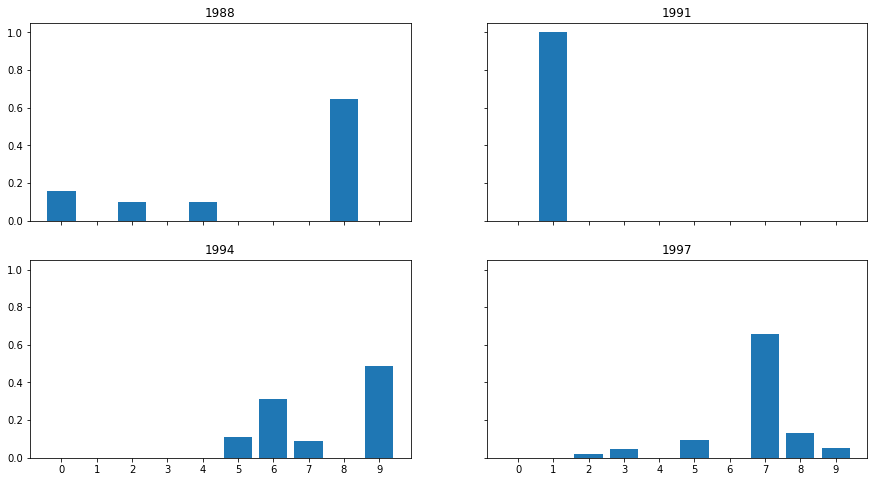

In [75]:
years, idx = np.unique(nips12_issue, return_index=True)
fig, ax = pyplot.subplots(2, 2, sharex = True, sharey=True, figsize=(15,8))
for i, year in enumerate(range(0,12,3)):
    i = np.unravel_index(i,(2,2))
    ax[i].set_title(year + 1988)
    ax[i].set_xticks(np.arange(10))
    ax[i].bar(range(10),gamma_normed[idx][year])

Выведите наиболее вероятные слова и наиболее вероятные документы для каждой темы. Воспользуйтесь функциями `lda.num_topics`, `lda.show_topic(topic, topn=10)`. Используйте нормализованные параметры $\gamma$, вычисленные ранее.

Проанализируйте результат. Как вы можете интерпретировать темы? Напишите ваши интерпретации хотя бы для трёх тем.

Замечание. Если вы нашли интересную статью в списке, вы можете скачать её онлайн, публикации конференции NIPS доступны бесплатно.

In [131]:
topdocs = np.argpartition(-gamma_normed, np.arange(10), axis=0)[:10,:]

In [132]:
for i in range(lda.num_topics):
    print('theme: {}'.format(i))
    print('titles:')
    for title in nips12_titles[topdocs[:,i]]:
        print('"'+title + '"')
        print()
    print('words:')
    print([j[0] for j in lda.show_topic(i, topn=20)])
    print()

theme: 0
titles:
"An Analog VLSI Model of Periodicity Extraction,"

"Simulations Suggest Information Processing Roles for the Diverse Currents in Hippocampal Neurons "

"A Contrast Sensitive Silicon Retina with Reciprocal Synapses "

"An Analog VLSI Model of the Fly Elementary Motion Detector,"

"Direction Selective Silicon Retina that uses Null Inhibition "

"A SILICON AXON "

"Visual Motion Computation in Analog VLSI using Pulses "

"Cholinergic Modulation Preserves Spike Timing Under Physiologically Realistic Fluctuating Input,"

"Feedback Synapse to Cone and Light Adaptation . "

"An Electronic Photoreceptor Sensitive to Small Changes in Intensity "

words:
['model', 'time', 'neuron', 'figure', 'neurons', 'cell', 'cells', 'input', 'motion', 'spike', 'system', 'circuit', 'response', 'neural', 'firing', 'output', 'current', 'signal', 'frequency', 'voltage']

theme: 1
titles:
"OCULAR DOMINANCE AND PATTERNED LATERAL CONNFL-TIONS IN A SELF-ORGANIZING MODEL OFTHE PRIMARY VISUAL CORTEX "


**тема 2**: обучение с подкреплением  
**тема 3**: распознавание речи  
**тема 4**: работа с последовательными данными и рекуррентными нейросетями  

Вычислите среднюю вероятность тем для каждого года. Проанализируйте какие темы становятся более популярны с теченим времени, а какие, наоборот, теряют популярность.

In [114]:
res = []
for i in range(13):
    mask = nips12_issue == i
    res += [gamma_normed[mask].mean(0)]
res = np.array(res)

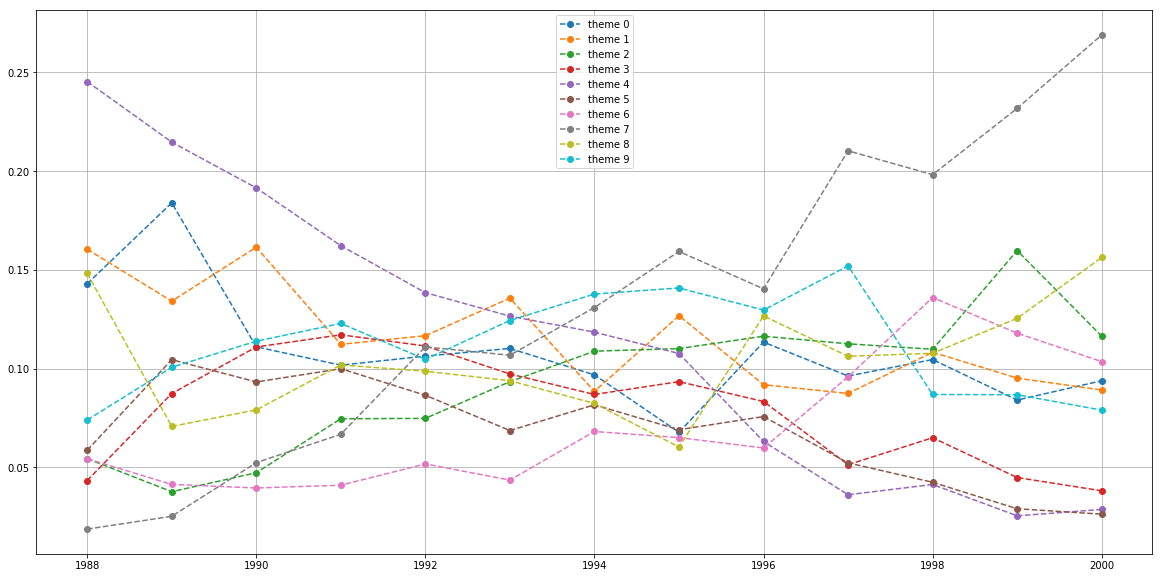

In [128]:
pyplot.figure(figsize=(20,10))
pyplot.grid(True)
for i in range(10):
    pyplot.plot(1988 + np.arange(13), res[:,i], '--o', label = 'theme {}'.format(i))
pyplot.legend()

In [ ]:
Обучение с подкреплением, методы связаные гауссовскими процессами, смесями гауссиан 

Используйте следующий код для отображения тем, найденных LSI (Latent Semantic Indexing) &mdash; невероятностной тематической моделью. Как можно интерпретироват полученные темы? Сравните время работы методов.

In [ ]:
lsi = gensim.models.LsiModel(full_corpus, num_topics=num_topics, id2word=nips12_id2word)
lsi.print_topics(10, num_words=20)

# Визуализация

Используйте следующий код для изображения тем вашей лучшей модели.

In [ ]:
class MyDictionary():
    def __init__(self, word2id):
        self.token2id = word2id
    
    def __len__(self):
        return len(self.token2id)

    
class MyScipy2Corpus(gensim.matutils.Scipy2Corpus):
    def __len__(self):
        return self.vecs.shape[0]



In [ ]:
lda.save('model.dat')

Установите библиотеку `pyLDAvis` с помощью `pip`

**Найдите две наиболее похожие темы.**

In [ ]:
import pyLDAvis.gensim

lda = gensim.models.LdaModel.load('model.dat')
my_full_corpus = MyScipy2Corpus(counts[subset_mask, :])
my_dictionary = MyDictionary(nips12_word2id)
data = pyLDAvis.gensim.prepare(lda, my_full_corpus, my_dictionary)
pyLDAvis.display(data)